In [1]:
path = "../input/scene_classification/scene_classification/train/"

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 32

In [4]:
df = pd.read_csv('../input/scene_classification/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
tfms = get_transforms(do_flip=True)
data = (ImageItemList.from_csv(path, csv_name='../train.csv') #Where to find the data? -> in path and its subfolders
        .random_split_by_pct()              #How to split in train/valid? -> use the folders
        .label_from_df()            #How to label? -> depending on the folder of the filenames
        .add_test_folder(test_folder = '../test')              #Optionally add a test set (here default name is test)
        .transform(tfms, size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

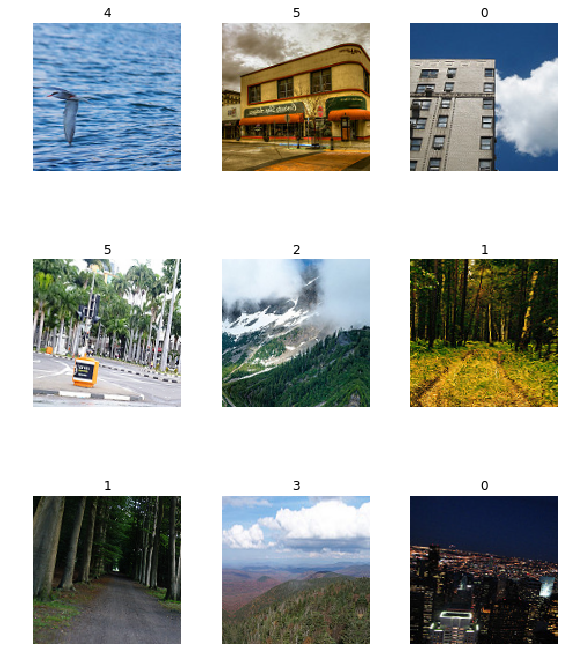

In [6]:
data.show_batch(rows=3, figsize=(8,10))

In [7]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [8]:
learn = create_cnn(data, models.resnet152, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 82508033.81it/s]


In [9]:
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.449155,0.345072,0.124486,0.875514
2,0.307133,0.250235,0.093365,0.906635
3,0.252573,0.210690,0.078391,0.921609
4,0.214056,0.201323,0.068409,0.931591
5,0.178291,0.190243,0.071051,0.928949
6,0.166913,0.186915,0.066060,0.933940
7,0.134267,0.187150,0.066941,0.933059


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)

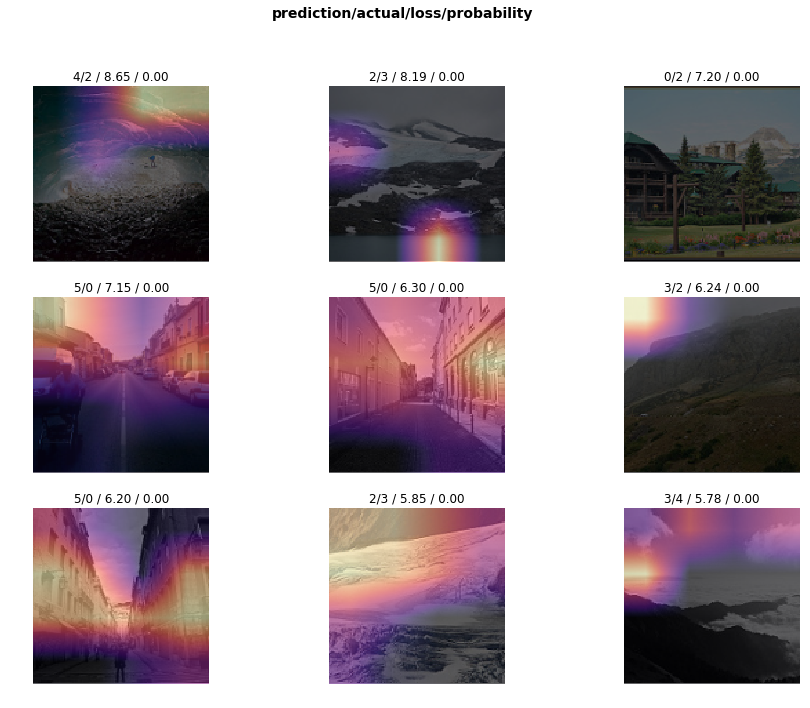

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

In [12]:
interp.most_confused(min_val=2)

[(3, 2, 66),
 (2, 3, 50),
 (0, 5, 34),
 (5, 0, 28),
 (4, 3, 12),
 (2, 4, 10),
 (4, 5, 4),
 (3, 4, 3),
 (4, 0, 3),
 (5, 1, 3)]

In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06


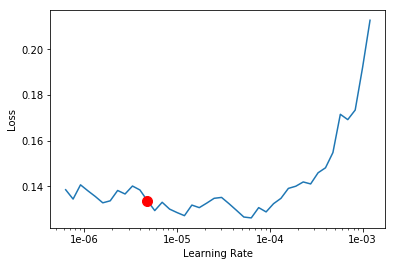

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-6, 2e-6))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.144853,0.187400,0.066941,0.933059
2,0.147833,0.185832,0.065473,0.934527
3,0.135477,0.185567,0.064592,0.935408
4,0.133555,0.185204,0.065766,0.934234
5,0.133223,0.184158,0.064298,0.935702
6,0.123106,0.184779,0.065179,0.934821
7,0.122154,0.183774,0.065179,0.934821


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


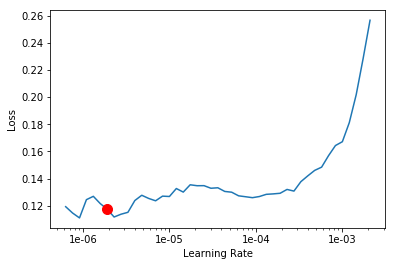

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
# learn.fit_one_cycle(10, max_lr=slice(1e-6, 2e-6))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


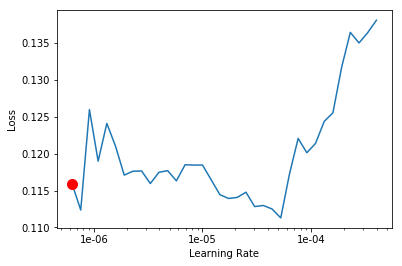

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 2.4e-6))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.116143,0.182408,0.064592,0.935408
2,0.120303,0.181162,0.065179,0.934821
3,0.114585,0.183772,0.063124,0.936876
4,0.113661,0.181071,0.065179,0.934821


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


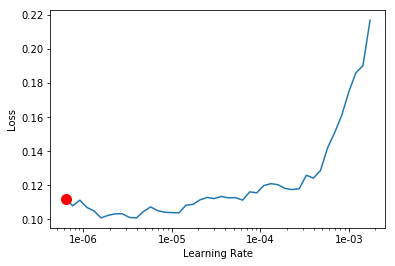

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(9e-7, 1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.109824,0.183333,0.064592,0.935408
2,0.111358,0.182694,0.065179,0.934821
3,0.109608,0.182841,0.065473,0.934527


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


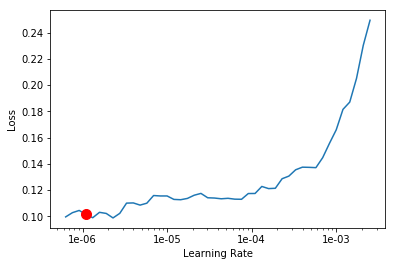

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(2e-6, 6e-5))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.119460,0.183305,0.064298,0.935702
2,0.111385,0.186810,0.067528,0.932472
3,0.092713,0.188612,0.063418,0.936583
4,0.072809,0.192529,0.065179,0.934821
5,0.064478,0.190597,0.064885,0.935115


In [26]:
learn.save('stage-2')

In [27]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
predsPrime = list(np.array(preds))

In [28]:
labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred)))
    
# labelled_preds[0:10]
len(labelled_preds)

7301

In [29]:
import os
filenames = os.listdir('../input/scene_classification/scene_classification/test/')

In [30]:
submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })

submissionPrime = pd.DataFrame(
    {'image_name': filenames,
     'label': predsPrime,
    })

In [31]:
y_test = submission
y_testPrime = submissionPrime

image_name = list(submission['image_name'])
label = list(submission['label'])

image_namePrime = list(submissionPrime['image_name'])
labelPrime = list(submissionPrime['label'])

for i in range(len(submission)):
    if i%1000 == 0:
            print(i)
    for j in range(len(submission)):
        if j+1 < len(submission) and int(image_name[j][:-4]) > int(image_name[j+1][:-4]) :
            temp = image_name[j]
            image_name[j] = image_name[j+1]
            image_name[j+1] = temp
            
            tempPrime =  label[j]
            label[j] = label[j+1]
            label[j+1] = tempPrime
            
            temp = image_namePrime[j]
            image_namePrime[j] = image_namePrime[j+1]
            image_namePrime[j+1] = temp
            
            tempPrime =  labelPrime[j]
            labelPrime[j] = labelPrime[j+1]
            labelPrime[j+1] = tempPrime
            
y_test['image_name'] = pd.DataFrame(image_name)
y_test['label'] = pd.DataFrame(label)
y_test.to_csv('S9.csv')

y_testPrime['image_name'] = image_namePrime
y_testPrime['label'] = labelPrime
y_testPrime.to_csv('R9.csv')

0
1000
2000
3000
4000
5000
6000
7000


In [32]:
y_testPrime.head()

,image_name,label
0,3.jpg,"[8.1091275e-05, 1.4376512e-07, 4.7335902e-07, ..."
1,5.jpg,"[0.9997129, 1.3407105e-05, 1.0685897e-05, 6.22..."
2,6.jpg,"[7.740193e-06, 8.3024985e-05, 0.0014446788, 0...."
3,11.jpg,"[1.5601154e-05, 0.0002756554, 0.5833322, 0.114..."
4,14.jpg,"[0.0016193156, 2.6800882e-07, 8.85156e-07, 9.5..."
